In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [89]:
df = pd.read_csv('WalmartSales.csv', parse_dates = ['Date'])

In [90]:
df.head(20)

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-05,50605.27
2,2010-02-05,13740.12
3,2010-02-05,39954.04
4,2010-02-05,32229.38
5,2010-02-05,5749.03
6,2010-02-05,21084.08
7,2010-02-05,40129.01
8,2010-02-05,16930.99
9,2010-02-05,30721.50


In [91]:
# format columns name
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [92]:
df = format_column_names(df)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          420212 non-null  datetime64[ns]
 1   weekly_sales  420212 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 MB


In [94]:
df = df.groupby(['date'])['weekly_sales'].sum().reset_index()

In [95]:
# df.set_index('date')

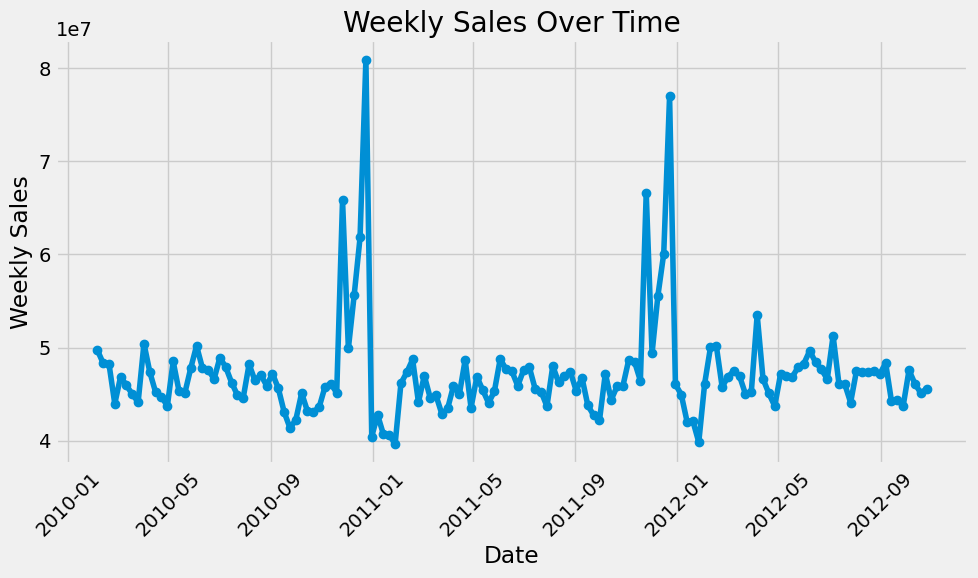

In [96]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['weekly_sales'], marker='o', linestyle='-')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

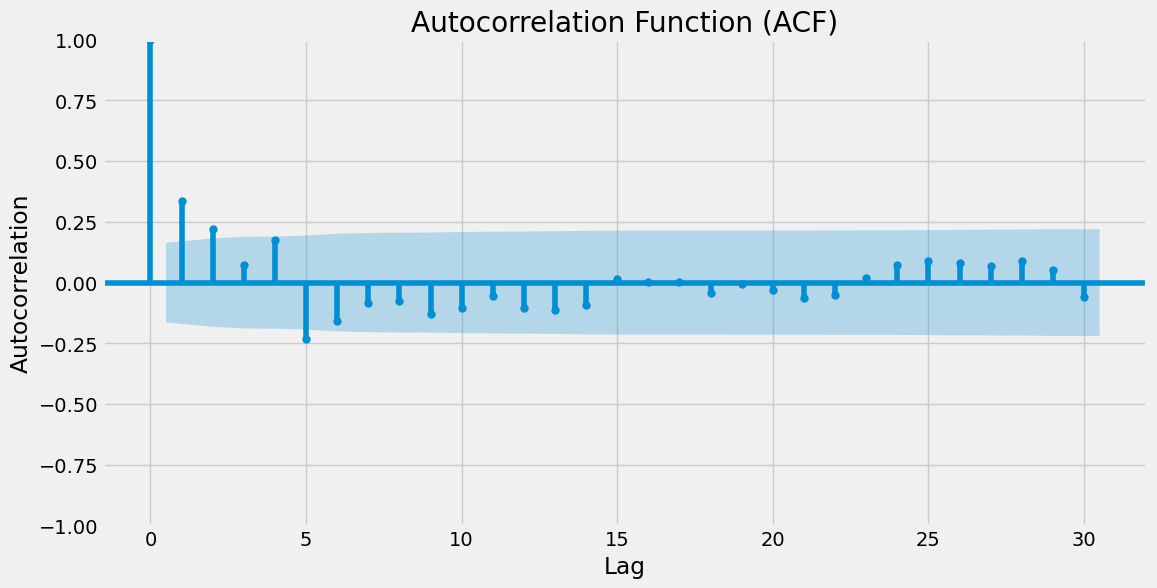

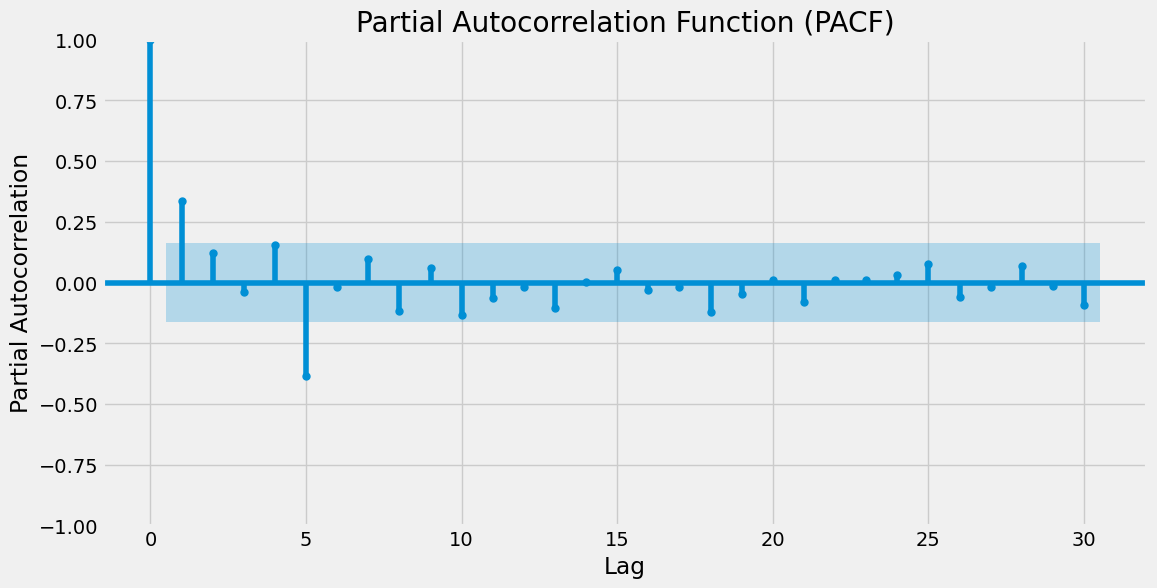

In [97]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=None):
    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and 'Oil' is the column you want to model
plot_acf_pacf(df['weekly_sales'], lags=30)  # You can adjust the number of lags as needed

In [106]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [107]:
df.dtypes

weekly_sales    float64
dtype: object

In [112]:
def differentiate_and_plot(series, diff_order):
    # Differentiate the series the specified number of times
    differentiated_series = series.diff(diff_order).dropna()
    
    # Plot the differentiated series
    plt.figure(figsize=(10, 6))
    plt.plot(differentiated_series.index, differentiated_series.values, label=f'{diff_order}th Order Difference')
    plt.title(f'{diff_order}th Order Difference of Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Perform ADF test to check stationarity
    result = adfuller(differentiated_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")


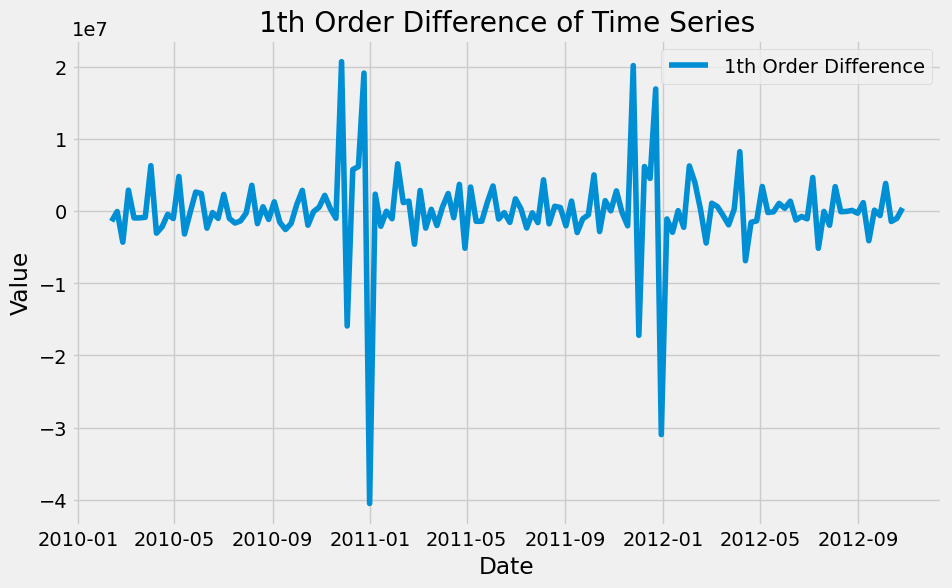

ADF Statistic: -6.699528058652874
p-value: 3.921308889570364e-09
Critical Values:
   1%: -3.480118600110386
   5%: -2.8833618426136196
   10%: -2.578407034974382
The differentiated series is likely stationary (reject the null hypothesis)


In [114]:
differentiate_and_plot(df['weekly_sales'], 1)

# Model

## ARIMA

In [109]:
def create_arima_model(df, column_name, p, d, q):
    # Convert the DataFrame column to a pandas Series
    series = df[column_name]
    
    # Split the data into training and testing sets (80-20 split)
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train, order=(p, d, q))
    fitted_model = model.fit()
    
    # Make predictions
    predictions = fitted_model.forecast(steps=len(test))
    
    # Visualize the training, testing, and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train.values, label='Training Data')
    plt.plot(test.index, test.values, label='Actual Test Data')
    plt.plot(test.index, predictions, color='red', label='Predicted Test Data')
    plt.title('ARIMA Model Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    #Forecasting another 24 months 
    final_model = ARIMA(df, order=(p,d,q)).fit()
    prediction=final_model.predict(len(df),len(df)+24)

    df.plot(legend=True, label='Train', figsize=(10,6))
    prediction.plot(legend=True, label='prediction')
    
    # Calculate and print RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print("Root Mean Squared Error (RMSE):", rmse)

c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting

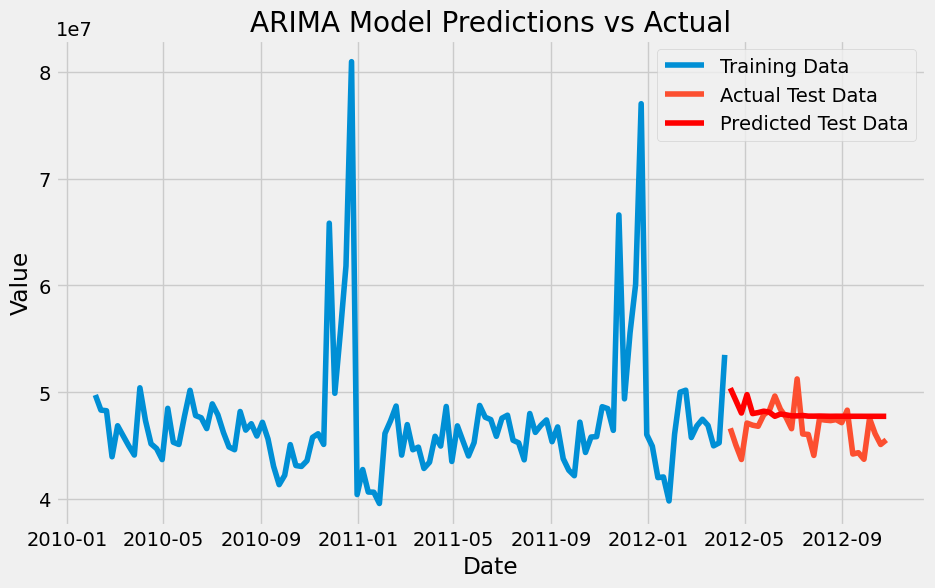

c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting

Root Mean Squared Error (RMSE): 2296415.469373465


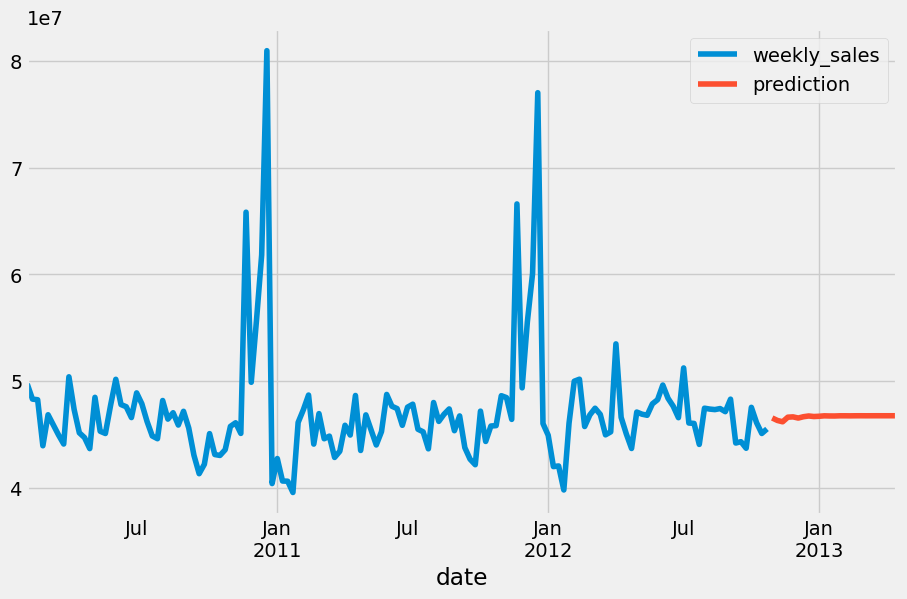

In [111]:
create_arima_model(df, 'weekly_sales', 4,1,3)

## AR Model

In [115]:

def differentiate_series(series, diff_order):
    # Differentiate the series the specified number of times
    differentiated_series = series.diff(diff_order).dropna()
    return differentiated_series

def create_ar_model(df, column_name, p, diff_order=0):
    # Convert the DataFrame column to a pandas Series
    series = df[column_name]
    
    # Plot the original series before differentiation
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Original Data')
    plt.title('Original Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    # Differentiate the series if diff_order is specified
    if diff_order > 0:
        differentiated_series = differentiate_series(series, diff_order)
    else:
        differentiated_series = series
    
    # Split the data into training and testing sets (80-20 split)
    train_size = int(len(differentiated_series) * 0.8)
    train, test = differentiated_series[:train_size], differentiated_series[train_size:]
    
    # Fit AR model
    model_ar = AutoReg(train, lags=p)
    fitted_model_ar = model_ar.fit()
    
    # Make predictions for differentiated series
    predictions_ar_diff = fitted_model_ar.predict(start=len(train), end=len(train)+len(test)-1)
    
    # Visualize the training, testing, and predictions for differentiated series
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train.values, label='Training Data')
    plt.plot(test.index, test.values, label='Actual Test Data')
    plt.plot(test.index, predictions_ar_diff, color='blue', label='Predicted Test Data (AR)')
    plt.title('AR Model Predictions vs Actual (Differentiated Series)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Forecasting another 24 months using AR for differentiated series
    final_model_ar_diff = AutoReg(differentiated_series, lags=p).fit()
    prediction_ar_diff = final_model_ar_diff.predict(start=differentiated_series.index[-1], end=differentiated_series.index[-1] + pd.DateOffset(months=24))

    # Integrate the forecasted differentiated values into the original series
    prediction_ar = series.iloc[-1] + np.cumsum(prediction_ar_diff)

    # Plotting AR prediction for the next 24 months on the original series
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Original Data')
    plt.plot(prediction_ar.index, prediction_ar.values, color='purple', label='Forecast (AR)')
    plt.title('AR Model Forecast for the Next 24 Months (Original Series)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions_ar_diff))
    print("Root Mean Squared Error (RMSE) for differentiated series:", rmse)

    # Perform ADF test to check stationarity for differentiated series
    result = adfuller(differentiated_series)
    print('ADF Statistic for differentiated series:', result[0])
    print('p-value for differentiated series:', result[1])
    print('Critical Values for differentiated series:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")


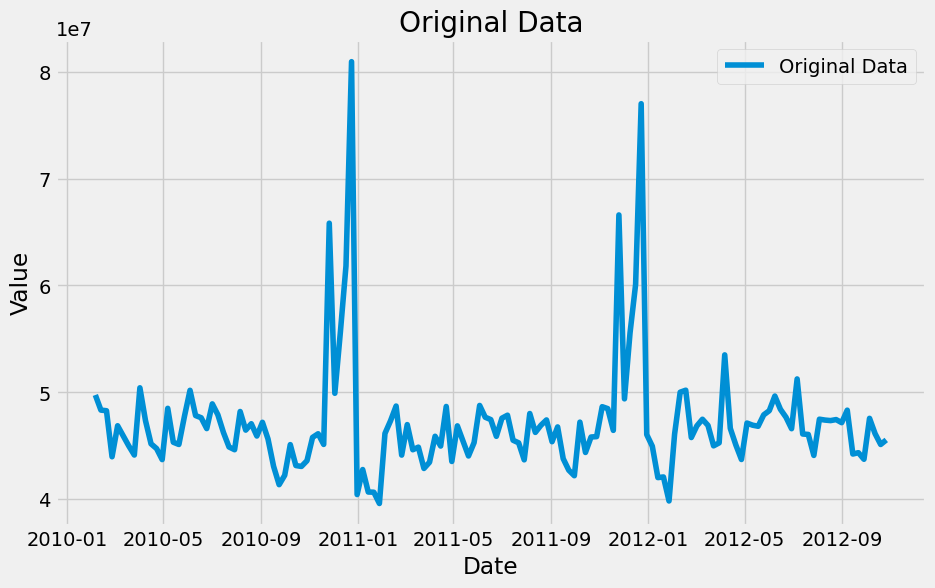

c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


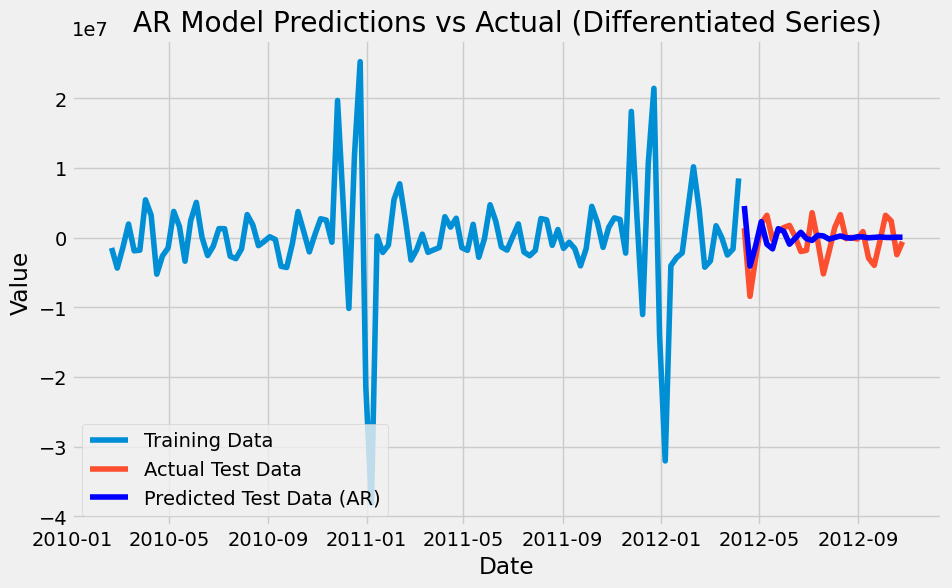

c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


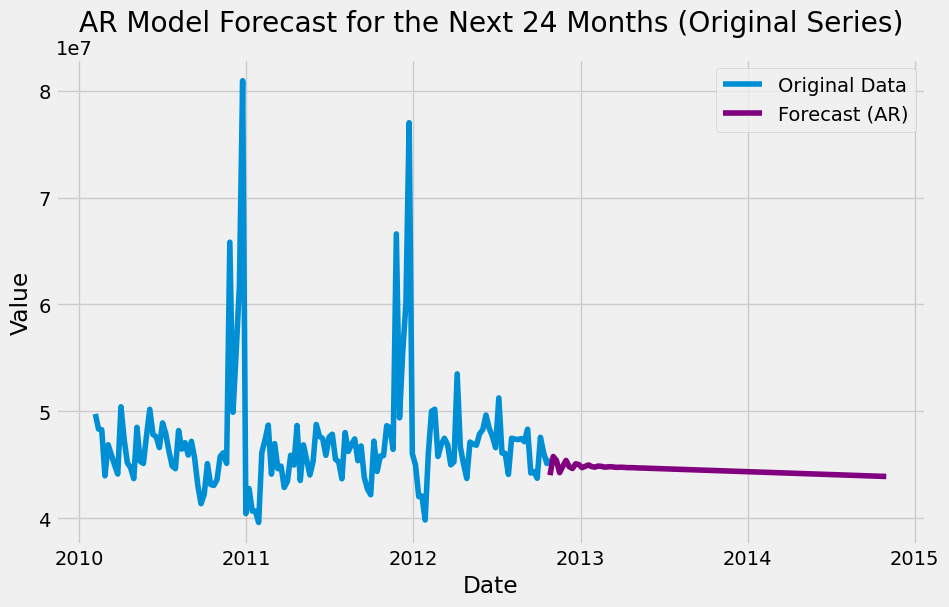

Root Mean Squared Error (RMSE) for differentiated series: 2478181.6266101776
ADF Statistic for differentiated series: -7.276982501941337
p-value for differentiated series: 1.535291953258934e-10
Critical Values for differentiated series:
   1%: -3.4793722137854926
   5%: -2.8830370378332995
   10%: -2.578233635380623
The differentiated series is likely stationary (reject the null hypothesis)


In [116]:
create_ar_model(df, 'weekly_sales', 4, diff_order=2)